In [32]:
import numpy as np
from collections import Counter, defaultdict
from scipy.sparse import csc_matrix, save_npz, load_npz
from itertools import combinations
import matplotlib.pyplot as plt
import json
import random
from os import listdir, path

In [33]:
# read .ped
individuals = set()
multiples = set()
with open('../../DATA/ancestry/ancestry.ped', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        
        if pieces[1] in individuals:
            multiples.add(pieces[1])
        individuals.add(pieces[1])
        individuals.add(pieces[2])
        individuals.add(pieces[3])
        
        
individuals = sorted(individuals)
individual_to_index = dict([(x, i) for i, x in enumerate(individuals)])
print('individuals', len(individuals))
print('multiples', multiples)

individuals 783
multiples set()


In [34]:
print('missing from .ped')

missing_from_ped = []
with open('../../DATA/ancestry/ancestry.ped', 'a') as f:

    for filename in listdir('../data/Ancestry Data files'):
        if filename.endswith('txt') and filename[:-4] not in individuals and filename != 'ancestry.ped.txt':
            try:
                if 'NT' in filename:
                    fam, phen, num = filename[:-4].split('_')
                    f.write('\t'.join(['FAM_%s' % fam, 
                                       '_'.join([fam, phen, num]), 
                                       '%s_DAD' % fam,
                                       '%s_MOM' % fam,
                                       '*',
                                       '1']) + '\n')
                    print(filename, 'adding %s to ped' % '_'.join([fam, phen, num]))
                    missing_from_ped.append(filename)
                elif 'ASD' in filename:
                    fam, phen, num = filename[:-4].split('_')
                    f.write('\t'.join(['FAM_%s' % fam, 
                                       '_'.join([fam, phen, num]), 
                                       '%s_DAD' % fam,
                                       '%s_MOM' % fam,
                                       '*',
                                       '2']) + '\n')
                    print(filename, 'adding %s to ped' % '_'.join([fam, phen, num]))
                    missing_from_ped.append(filename)

            except ValueError:
                print(filename)
print(missing_from_ped)

missing from .ped
CDI1314_NONASD_1.txt adding CDI1314_NONASD_1 to ped
['CDI1314_NONASD_1.txt']


In [35]:
# check that everything matches
with open('../../DATA/ancestry/ancestry.ped', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        #print(pieces)
        fam, phen, num = pieces[1].split('_')
        try:
            assert pieces[0][4:] == fam
            assert pieces[2] == '%s_DAD' % fam
            assert pieces[3] == '%s_MOM' % fam
            if phen == 'ASD':
                assert pieces[5] == '2'
            elif phen == 'NT':
                assert pieces[5] == '1'
        except AssertionError:
            print('ERROR', line)

In [36]:
# see if we're missing data for anyone
for ind in individuals:
    if not path.isfile('../data/Ancestry Data files/%s.txt' % ind):
        print('missing data', ind)

missing data 1582_ASD_1
missing data 1625_DAD
missing data ARI019a_DAD
missing data CDI076_DAD
missing data CDI1329a_DAD
missing data CWM91_ASD_1
missing data MM2000_DAD


In [40]:
# pull positions
positions = []
with open('../data/Ancestry Data files/%s.txt' % individuals[0], 'r') as f:
    line = next(f)
    while line.startswith('#'):
        line = next(f)
    for line in f:
        pieces = line.strip().split('\t')
        positions.append((int(pieces[1]), int(pieces[2])))
        
# remove positions that occur multiple times (CNV probes)
positions = sorted([k for k, v in Counter(positions).items() if v==1])
print('positions', len(positions))



positions 676594


In [41]:
positions_set = set(positions)

In [42]:
# pull reference at these positions
chrom_to_int = dict([('chr%d' % d, d) for d in range(1, 23)])
chrom_to_int['chrX'] = 23
chrom_to_int['chrY'] = 24

chrom = None
pos_to_ref = dict()
with open('../data/hg19.fa', 'r') as f:
    for line in f:
        if line.startswith('>'):
            if chrom is not None:
                for p in pos:
                    assert (chrom_to_int[chrom], p) in pos_to_ref
            
            # pull out data
            chrom = line.strip()[1:]
            pos = [] if chrom not in chrom_to_int else [x[1] for x in positions if x[0] == chrom_to_int[chrom]]
            pos_index = 0
            current_pos = 1
            print(chrom, len(pos))
        else:
            line = line.strip()
            if pos_index == len(pos):
                # we're done with positions for this chromosome
                pass
            elif current_pos + len(line) <= pos[pos_index]:
                # no positions of interest here
                pass
            else:
                while pos_index < len(pos) and pos[pos_index]-current_pos < len(line):
                    pos_to_ref[(chrom_to_int[chrom], pos[pos_index])] = line[pos[pos_index]-current_pos]
                    pos_index += 1
            current_pos += len(line)
                


chr1 50552
chr2 54719
chr3 43186
chr4 36866
chr5 38798
chr6 43325
chr7 34609
chrX 25178
chr8 32969
chr9 29623
chr10 32779
chr11 32503
chr12 31280
chr13 24617
chr14 21134
chr15 21341
chr16 23332
chr17 22629
chr18 18987
chr20 18077
chrY 1668
chr19 16969
chr22 10986
chr21 10170
chr6_ssto_hap7 0
chr6_mcf_hap5 0
chr6_cox_hap2 0
chr6_mann_hap4 0
chr6_apd_hap1 0
chr6_qbl_hap6 0
chr6_dbb_hap3 0
chr17_ctg5_hap1 0
chr4_ctg9_hap1 0
chr1_gl000192_random 0
chrUn_gl000225 0
chr4_gl000194_random 0
chr4_gl000193_random 0
chr9_gl000200_random 0
chrUn_gl000222 0
chrUn_gl000212 0
chr7_gl000195_random 0
chrUn_gl000223 0
chrUn_gl000224 0
chrUn_gl000219 0
chr17_gl000205_random 0
chrUn_gl000215 0
chrUn_gl000216 0
chrUn_gl000217 0
chr9_gl000199_random 0
chrUn_gl000211 0
chrUn_gl000213 0
chrUn_gl000220 0
chrUn_gl000218 0
chr19_gl000209_random 0
chrUn_gl000221 0
chrUn_gl000214 0
chrUn_gl000228 0
chrUn_gl000227 0
chr1_gl000191_random 0
chr19_gl000208_random 0
chr9_gl000198_random 0
chr17_gl000204_random 0
chrUn_

In [43]:
print(len(individuals))

783


In [44]:
ns = {'A', 'C', 'G', 'T'}
def find_genotype(ref, allele1, allele2):
    if allele1 in ns and allele2 in ns and ref in ns:
        return (allele1 != ref) + (allele2 != ref)
    return -1

def pull_ancestry_data(individual):
    chroms, positions, genotypes = [], [], []
    try:
        with open('../data/Ancestry Data files/%s.txt' % individual, 'r') as f:
            line = next(f)
            while line.startswith('#'):
                line = next(f)
            assert line == 'rsid\tchromosome\tposition\tallele1\tallele2\n'
            for line in f:
                pieces = line.strip().split('\t')
                if len(pieces) >= 5:
                    chrom_int = int(pieces[1])
                    pos = int(pieces[2])
                    if (chrom_int, pos) in positions_set and (chrom_int, pos) in pos_to_ref:
                        ref = pos_to_ref[(chrom_int, pos)].upper()
                        genotype = find_genotype(ref, pieces[3], pieces[4])

                        chroms.append(chrom_int)
                        positions.append(pos)
                        genotypes.append(genotype)
                elif len(pieces) < 5:
                    print(pieces)
    except FileNotFoundError:
        print('File not found', individual)
    return np.array(chroms), np.array(positions), np.array(genotypes)
    

In [46]:
ancestry_data = dict()
for ind in individuals:
    print(ind, end=' ')
    ancestry_data[ind] = pull_ancestry_data(ind)

041_ASD_1 041_DAD 041_MOM 041_NT_1 041_NT_2 041_NT_3 072_ASD_1 072_DAD 072_MOM 072_NT_1 0783_ASD_1 0783_DAD 0783_MOM 0783_NT_1 1012_ASD_1 1012_ASD_2 1012_DAD 1012_MOM 1012_NT_1 1030_DAD 1030_MOM 1030_NT_1 1030_NT_2 1031_ASD_1 1031_DAD 1031_MOM 1031_NT_1 1031_NT_2 1035_ASD_1 1035_DAD 1035_MOM 1035_NT_1 1035_NT_2 1039_ASD_1 1039_DAD 1039_MOM 1039_NT_1 1046_ASD_1 1046_ASD_2 1046_DAD 1046_MOM 1046_NT_1 1047_ASD_1 1047_DAD 1047_MOM 1048_ASD_1 1048_DAD 1048_MOM 1048_NT_1 1049_DAD 1049_MOM 1049_NT_1 1049_NT_2 1052_ASD_1 1052_DAD 1052_MOM 1052_NT_1 1053_ASD_1 1053_DAD 1053_MOM 1053_NT_1 1053_NT_2 1055_ASD_1 1055_DAD 1055_MOM 1055_NT_1 1059_ASD_1 1059_DAD 1059_MOM 1059_NT_1 1060_ASD_1 1060_DAD 1060_MOM 1060_NT_1 1065_ASD_1 1065_ASD_2 1065_DAD 1065_MOM 1065_NT_1 1068_ASD_1 1068_DAD 1068_MOM 1068_NT_1 1070_ASD_1 1070_DAD 1070_MOM 1070_NT_1 1079_ASD_1 1079_DAD 1079_MOM 1079_NT_1 1080_ASD_1 1080_DAD 1080_MOM 1080_NT_1 1081_ASD_1 1081_DAD 1081_MOM 1082_ASD_1 1082_DAD 1082_MOM 1082_NT_1 1087a_ASD_1 1

CWM91_DAD CWM91_MOM CWM91_NT_1 CWM91_NT_2 CWM91_NT_3 CWM92_ASD_1 CWM92_DAD CWM92_MOM CWM92_NT_1 CWR007_ASD_1 CWR007_DAD CWR007_MOM CWR007_NT_1 CWR007_NT_2 CWR019_ASD_1 CWR019_DAD CWR019_MOM CWR019_NT_1 CWR058_ASD_1 CWR058_DAD CWR058_MOM CWR058_NT_1 CWR065_ASD_1 CWR065_DAD CWR065_MOM CWR065_NT_1 CWR065_NT_2 CWR081_ASD_1 CWR081_DAD CWR081_MOM CWR081_NT_1 CWR125a_ASD_1 CWR125a_ASD_2 CWR125a_DAD CWR125a_MOM CWR125a_NT_1 CWR161_ASD_1 CWR161_DAD CWR161_MOM CWR161_NT_1 CWR175_ASD_1 CWR175_DAD CWR175_MOM CWR175_NT_1 CWR256_ASD_1 CWR256_DAD CWR256_MOM CWR256_NT_1 CWR256_NT_2 CWR285_ASD_1 CWR285_ASD_2 CWR285_DAD CWR285_MOM CWR285_NT_1 CWR285_NT_2 CWR285_NT_3 MM2000_ASD_1 MM2000_DAD File not found MM2000_DAD
MM2000_MOM MM2000_NT_1 MM2000_NT_2 r2000_ASD_1 r2000_DAD r2000_MOM r2000_NT_1 

In [47]:
print(positions[:1])

[(1, 752721)]


In [48]:
for chrom, chrom_int in chrom_to_int.items():
    print(chrom)
    poss = [x[1] for x in positions if x[0] == chrom_int]
    pos_to_index = dict([(x, i) for i, x in enumerate(poss)])
    coordinates = np.zeros((len(poss), 4), dtype=int)
    coordinates[:, 0] = chrom_int
    coordinates[:, 1] = poss
    coordinates[:, 2:] = 1


    gen = -np.ones((len(individuals), len(poss)), dtype=np.int8)
    for i, individual in enumerate(individuals):
        if i%100==0:
            print(i, end=' ')
        ind_chroms, ind_positions, ind_genotypes = ancestry_data[individual]
        to_include = (ind_chroms == chrom_int)
        ind_positions = ind_positions[to_include]
        ind_genotypes = ind_genotypes[to_include]
        to_include = np.array([(x in pos_to_index) for x in ind_positions])
        if np.sum(to_include)>0:
            gen[i, np.array([pos_to_index[x] for x in ind_positions if x in pos_to_index])] = ind_genotypes[to_include]

    # throw out individuals where more than 10% of variants are missing
    #ind_indices = np.sum(gen==-1, axis=1)/len(poss) < 0.1
    #individuals = [ind for ind, include in zip(individuals, ind_indices)]
    #gen = gen[ind_indices, :]
    #print('missing individuals', np.sum(~ind_indices)/len(individuals))
    
    if chrom != 'chrX':
        # throw out sites where more than 10% of individuals are missing
        coordinates[np.sum(gen==-1, axis=0)/len(individuals) >= 0.1, 3] = 0
        print('missing variants', np.sum(coordinates[:, 3]==0)/len(poss))


    save_npz('../../DATA/ancestry/genotypes/chr.%s.0.gen' % (str(chrom_int) if chrom_int < 23 else 'X' if chrom_int==23 else 'Y'), csc_matrix(gen))
    np.save('../../DATA/ancestry/genotypes/chr.%s.0.gen.coordinates' % (str(chrom_int) if chrom_int < 23 else 'X' if chrom_int==23 else 'Y'), coordinates)


chr1
0 100 200 300 400 500 600 700 missing variants 0.009930368729229309
chr2
0 100 200 300 400 500 600 700 missing variants 0.01681317275535006
chr3
0 100 200 300 400 500 600 700 missing variants 0.010883156578520818
chr4
0 100 200 300 400 500 600 700 missing variants 0.005045299191667118
chr5
0 100 200 300 400 500 600 700 missing variants 0.010876849322130006
chr6
0 100 200 300 400 500 600 700 missing variants 0.007224466243508367
chr7
0 100 200 300 400 500 600 700 missing variants 0.009679563119419804
chr8
0 100 200 300 400 500 600 700 missing variants 0.006612272134429312
chr9
0 100 200 300 400 500 600 700 missing variants 0.008405630759882524
chr10
0 100 200 300 400 500 600 700 missing variants 0.006742121480215992
chr11
0 100 200 300 400 500 600 700 missing variants 0.016736916592314556
chr12
0 100 200 300 400 500 600 700 missing variants 0.011317135549872123
chr13
0 100 200 300 400 500 600 700 missing variants 0.0328228460007312
chr14
0 100 200 300 400 500 600 700 missing varian

In [49]:
from itertools import compress
import json

with open('../../DATA/ancestry/genotypes/samples.json', 'w+') as f:
    json.dump(individuals, f)
    
with open('../../DATA/ancestry/genotypes/info.json', 'w+') as f:
    json.dump({
                    "assembly": "37",
                    "vcf_directory": "Ancestry Data files",
                    "batch_size": -1
              }, f)


In [50]:
print(len(individuals), gen.shape)

783 (783, 1668)


# Pull data

In [53]:
chroms = [str(x) for x in range(1, 23)] + ['X', 'Y']
all_coords = []
all_gens = []

for chrom in chroms:
    all_gens.append(load_npz('../../DATA/ancestry/genotypes/chr.%s.0.gen.npz' % chrom).A)
    all_coords.append(np.load('../../DATA/ancestry/genotypes/chr.%s.0.gen.coordinates.npy' % chrom))

coordinates = np.vstack(all_coords)
gen = np.hstack(all_gens)

with open('../../DATA/ancestry/genotypes/samples.json', 'r') as f:
    individuals = json.load(f)
    
print(len(individuals), gen.shape, coordinates.shape)
                      
individual_to_index = dict([(x, i) for i, x in enumerate(individuals)])

783 (783, 676297) (676297, 4)


# Check sex

In [70]:
parents_to_children = defaultdict(list)
individual_to_sex = dict()
with open('../../DATA/ancestry/ancestry.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
        individual_to_sex[pieces[1]] = pieces[4]
        individual_to_sex[pieces[2]] = '1'
        individual_to_sex[pieces[3]] = '2'

In [71]:
is_m = np.array([individual_to_sex[x]=='1' for x in individuals])
is_f = np.array([individual_to_sex[x]=='2' for x in individuals])

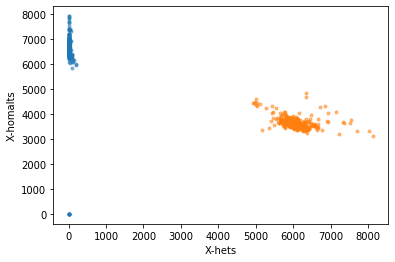

In [72]:
num_X_hets = np.sum(gen[:, coordinates[:, 0]==23]==1, axis=1)
num_X_homalts = np.sum(gen[:, coordinates[:, 0]==23]==2, axis=1)
plt.scatter(num_X_hets[is_m],
            num_X_homalts[is_m],
            label='male', alpha=0.5, marker='.')
plt.scatter(num_X_hets[is_f],
            num_X_homalts[is_f],
            label='female', alpha=0.5, marker='.')
plt.xlabel('X-hets')
plt.ylabel('X-homalts')
plt.show()

In [73]:
print('labelled F, should be M',
      [individuals[i] for i in np.where((num_X_homalts>1000) & (num_X_hets < 1000) & is_f)[0]])
print('labelled M, should be F',
      [individuals[i] for i in np.where((num_X_homalts>1000) & (num_X_hets > 1000) & is_m)[0]])
print('missing sex, should be M',
      [individuals[i] for i in np.where((num_X_homalts>1000) & (num_X_hets < 1000) & ~(is_m | is_f))[0]])
print('missing sex, should be F',
      [individuals[i] for i in np.where((num_X_homalts>1000) & (num_X_hets > 1000) & ~(is_m | is_f))[0]])

labelled F, should be M []
labelled M, should be F []
missing sex, should be M []
missing sex, should be F []


# Check relationships

In [74]:
moms, dads, childs = [], [], []
mom_indices, dad_indices, child_indices = [], [], []
for (mom, dad), children in parents_to_children.items():
    for child in children:
        if mom in individual_to_index and dad in individual_to_index and child in individual_to_index:
            mom_indices.append(individual_to_index[mom])
            dad_indices.append(individual_to_index[dad])
            child_indices.append(individual_to_index[child])
            
            moms.append(mom)
            dads.append(dad)
            childs.append(child)


(783, 649451)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


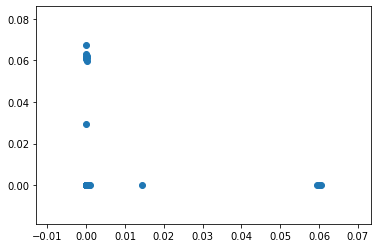

In [75]:
autosomal_gen = gen[:, coordinates[:, 0]<23]
print(autosomal_gen.shape)

num_mom_errors = np.sum((autosomal_gen[mom_indices, :]==0) & (autosomal_gen[child_indices, :]==2), axis=1)
num_mom_errors += np.sum((autosomal_gen[mom_indices, :]==2) & (autosomal_gen[child_indices, :]==0), axis=1)
num_mom_errors = num_mom_errors/np.sum((autosomal_gen[mom_indices, :]>=0) & (autosomal_gen[child_indices, :]>=0), axis=1)

num_dad_errors = np.sum((autosomal_gen[dad_indices, :]==0) & (autosomal_gen[child_indices, :]==2), axis=1)
num_dad_errors += np.sum((autosomal_gen[dad_indices, :]==2) & (autosomal_gen[child_indices, :]==0), axis=1)
num_dad_errors = num_dad_errors/np.sum((autosomal_gen[dad_indices, :]>=0) & (autosomal_gen[child_indices, :]>=0), axis=1)

plt.scatter(num_mom_errors, num_dad_errors)
plt.show()

In [76]:
num_sib_errors = []
num_unrelated_errors = []
for (mom, dad), children in parents_to_children.items():
    for child1, child2 in combinations(children, 2):
        if child1 in individual_to_index and child2 in individual_to_index:
            child1_index, child2_index = individual_to_index[child1], individual_to_index[child2]
            num_sib_err = np.sum((autosomal_gen[child1_index, :]==0) & (autosomal_gen[child2_index, :]==2))
            num_sib_err += np.sum((autosomal_gen[child1_index, :]==2) & (autosomal_gen[child2_index, :]==0))
            num_sib_errors.append(num_sib_err/np.sum((autosomal_gen[child1_index, :]>=0) & (autosomal_gen[child2_index, :]>=0)))
    if mom in individual_to_index and dad in individual_to_index:
        mom_index, dad_index = individual_to_index[mom], individual_to_index[dad]
        num_unrel_err = np.sum((autosomal_gen[mom_index, :]==0) & (autosomal_gen[dad_index, :]==2))
        num_unrel_err += np.sum((autosomal_gen[mom_index, :]==2) & (autosomal_gen[dad_index, :]==0))
        num_unrelated_errors.append(num_unrel_err/np.sum((autosomal_gen[mom_index, :]>=0) & (autosomal_gen[dad_index, :]>=0)))

num_sib_errors = np.array(num_sib_errors)
num_unrelated_errors = np.array(num_unrelated_errors)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in long_scalars


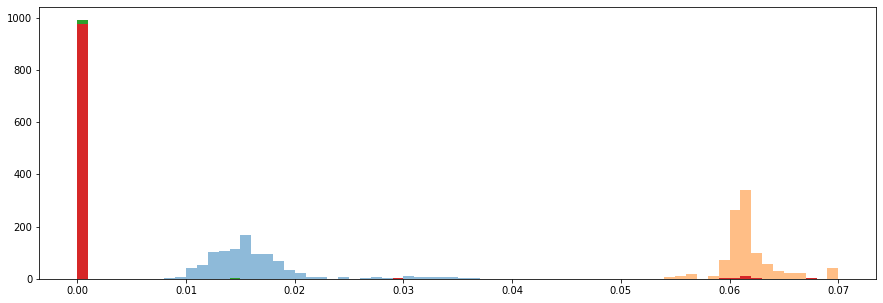

In [77]:
plt.figure(figsize=(15, 5))

plt.hist(np.clip(num_sib_errors, 0, 0.07), alpha=0.5, bins=np.arange(0, 0.071, 0.001), density=True)
plt.hist(np.clip(num_unrelated_errors, 0, 0.07), alpha=0.5, bins=np.arange(0, 0.071, 0.001), density=True)
plt.hist(np.clip(num_mom_errors, 0, 0.07), bins=np.arange(0, 0.071, 0.001), density=True)
plt.hist(np.clip(num_dad_errors, 0, 0.07), bins=np.arange(0, 0.071, 0.001), density=True)
plt.show()

In [78]:
print('moms')
print([moms[i] for i in np.where(num_mom_errors>0.01)[0]])
print([childs[i] for i in np.where(num_mom_errors>0.01)[0]])

print('dads')
print([dads[i] for i in np.where(num_dad_errors>0.01)[0]])
print([childs[i] for i in np.where(num_dad_errors>0.01)[0]])

moms
['1482_MOM', '1482_MOM', 'CDI315_MOM', 'CWM92_MOM']
['1482_ASD_1', '1482_NT_1', 'CDI315_NT_2', 'CWM92_ASD_1']
dads
['1152_DAD', '1461_DAD', '1672_DAD', 'CDI268_DAD', 'CDI314_DAD', '1410_DAD', '1378_DAD', 'CWM92_DAD', 'CWI117_DAD', 'CWI117_DAD']
['1152_NT_1', '1461_ASD_2', '1672_ASD_1', 'CDI268_ASD_2', 'CDI314_ASD_1', '1410_ASD_1', '1378_NT_1', 'CWM92_NT_1', 'CWI117_NT_1', 'CWI117_NT_2']


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


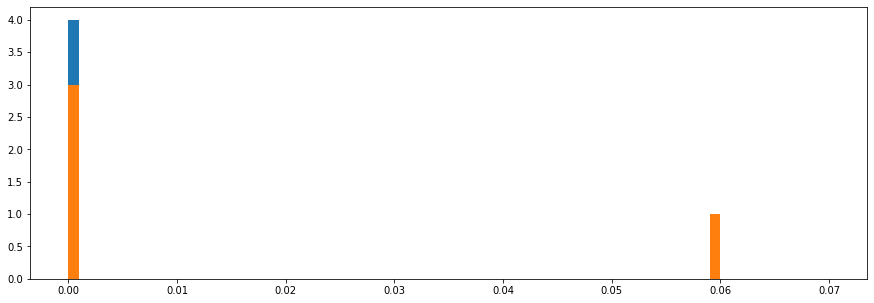

In [79]:
plt.figure(figsize=(15, 5))

plt.hist(np.clip(num_mom_errors[['1152' in mom for mom in moms]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.hist(np.clip(num_dad_errors[['1152' in dad for dad in dads]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.show()

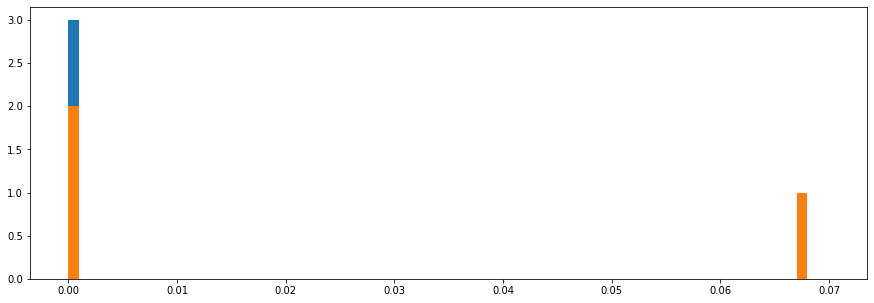

In [80]:
plt.figure(figsize=(15, 5))

plt.hist(np.clip(num_mom_errors[['1461' in mom for mom in moms]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.hist(np.clip(num_dad_errors[['1461' in dad for dad in dads]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.show()